### Obtaining CHIRPS Data in NETCDF format and using XArray, Dask for analysis

In [1]:
import dask
import dask.array as da
import xarray as xr
import rioxarray as rx
import rasterio
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import cftime
import matplotlib.pyplot as plt
from xrspatial.zonal import stats as zonal_stats
from xrspatial.zonal import crosstab as zonal_crosstab
from geocube.api.core import make_geocube

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

#### File path to data 

In [3]:
chirps2018_nc = './data/netcdf/chirps-v2.0.2018.pentads.nc'
geojson_path = './data/geojson/kerala_boundary.geojson'
kerala_districts = 'district.geojson'

#### Open the NetCDF file using rioxarray

In [ ]:
chirps_ds = rx.open_rasterio(chirps2018_nc, masked=True, chunks={'time': 'auto'})
# Define the WGS84 CRS
wgs84_crs = "+proj=longlat +datum=WGS84 +no_defs"
chirps_ds = chirps_ds.rio.write_crs(wgs84_crs,inplace=True)
chirps_ds.rio.crs

#### Read GeoJson and Clip data to study Area

In [12]:
kerala_gdf = gpd.read_file(kerala_districts)
gdf = gpd.read_file(geojson_path)
geometry = shape(gdf.geometry.iloc[0])
# Clip the rioxarray dataset using the mask
clipped_chirps_ds = chirps_ds.rio.clip([geometry], drop =True)
# If you want to save the result to a new file
clipped_chirps_ds.to_netcdf('kerala_chirps_pentad_2018.nc')

In [11]:
chirps_kerala_2018 = './netcdf_files/kerala_chirps_pentad_2018.nc'

##### Open the NetCDF file using rioxarray

In [12]:
kerala_chirps_ds = rx.open_rasterio(chirps_kerala_2018, masked=True,chunks={'time': 'auto'})
datetimeindex = kerala_chirps_ds.indexes['time'].to_datetimeindex()
kerala_chirps_ds['time'] = datetimeindex

#### Filter Monsoon data

In [16]:
# Filter the dataset to include only months 6, 7, 8, and 9
kerala_monsoon_chirps = kerala_chirps_ds.sel(time=kerala_chirps_ds['time'].dt.month.isin([6, 7, 8, 9]))
kerala_monsoon_2018 = kerala_monsoon_chirps.sum(dim=['time'], skipna=True)

#### Plot Monsoon Rainfall Data

/tmp/ipykernel_508/2588602787.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(kerala_gdf.geometry.centroid.x, kerala_gdf.geometry.centroid.y, kerala_gdf['DISTRICT']):


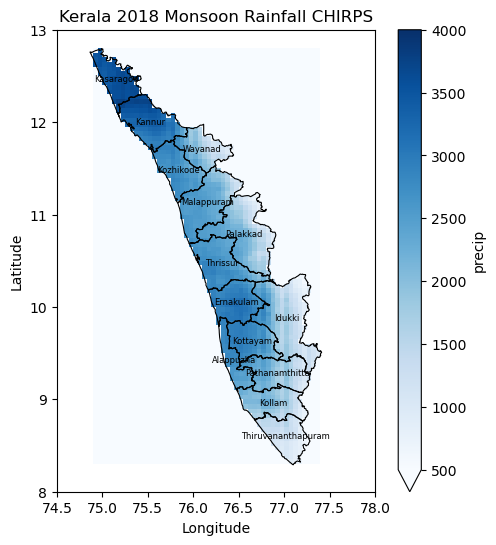

In [73]:
fig, ax = plt.subplots(figsize=(6, 6))
kerala_gdf.boundary.plot(ax =ax, color='black',linewidth=0.8 )
im = kerala_monsoon_2018.plot(ax=ax, cmap='Blues', vmin=500, vmax=4000)
ax.set_xlim([74.5, 78])  # Adjust the longitude range
ax.set_ylim([8, 13])   # Adjust the latitude range
# Add labels for each district
for x, y, label in zip(kerala_gdf.geometry.centroid.x, kerala_gdf.geometry.centroid.y, kerala_gdf['DISTRICT']):
    ax.text(x, y, label, fontsize=6,color= 'black', ha='center', va='center')

# Display values on the plot without adding text
cbar = plt.colorbar(img, label='Precipitation in mm')
cbar.ax.tick_params(labelsize=10)
plt.title('Kerala 2018 Monsoon Rainfall CHIRPS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
